In [1]:
#lets make our first model!!!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import nbimporter
import seaborn as sns


In [6]:
#our first model will be a simple decision tree model. since its a multiclass problem we will use the DecisionTreeClassifier from sklearn.
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from library import load_data
data = load_data()
data.shape


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


(20058, 16)

In [ ]:
# lets use our preprocessing class to make the data numeric and ready for the model
from library import preprocess_data
classinst = preprocess_data(data)
procd = classinst.make_num(feature_engineering=True)
procd.head()


#now lets split the data into training and testing sets
# the model expects int, not float for the target variable, so we convert it
y = procd['win_num'].map({1.0: 2, 0.5: 1, 0.0: 0}).astype(int)

X = procd.drop('win_num', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#lets create a model instance and fit it to the training data. first we do it with default parameters, then we tune afterwards.

model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=10)
model.fit(X_train, y_train)

#lets evaluate the model with score (r2) and confusion matrix
print("Model Score:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
# 0.62 is pretty accurate for a prediction on wins (especially on a dumb model like this one)
# . I think the data is lobsided in a way that makes it easy to predict who wins because of high elo differences.





Model Score: 0.6271186440677966
Confusion Matrix:
 [[1029    1  786]
 [ 104    0   88]
 [ 517    0 1487]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.57      0.59      1816
           1       0.00      0.00      0.00       192
           2       0.63      0.74      0.68      2004

    accuracy                           0.63      4012
   macro avg       0.42      0.44      0.43      4012
weighted avg       0.60      0.63      0.61      4012

Accuracy: 0.6271186440677966


In [ ]:
#after making the model: gridsearch for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

#weirdly enough, the best parameters are worse then the default parameters we used before. so we will stick with the default parameters for this model.


Best Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 10}
Best Score: 0.6212144581681777


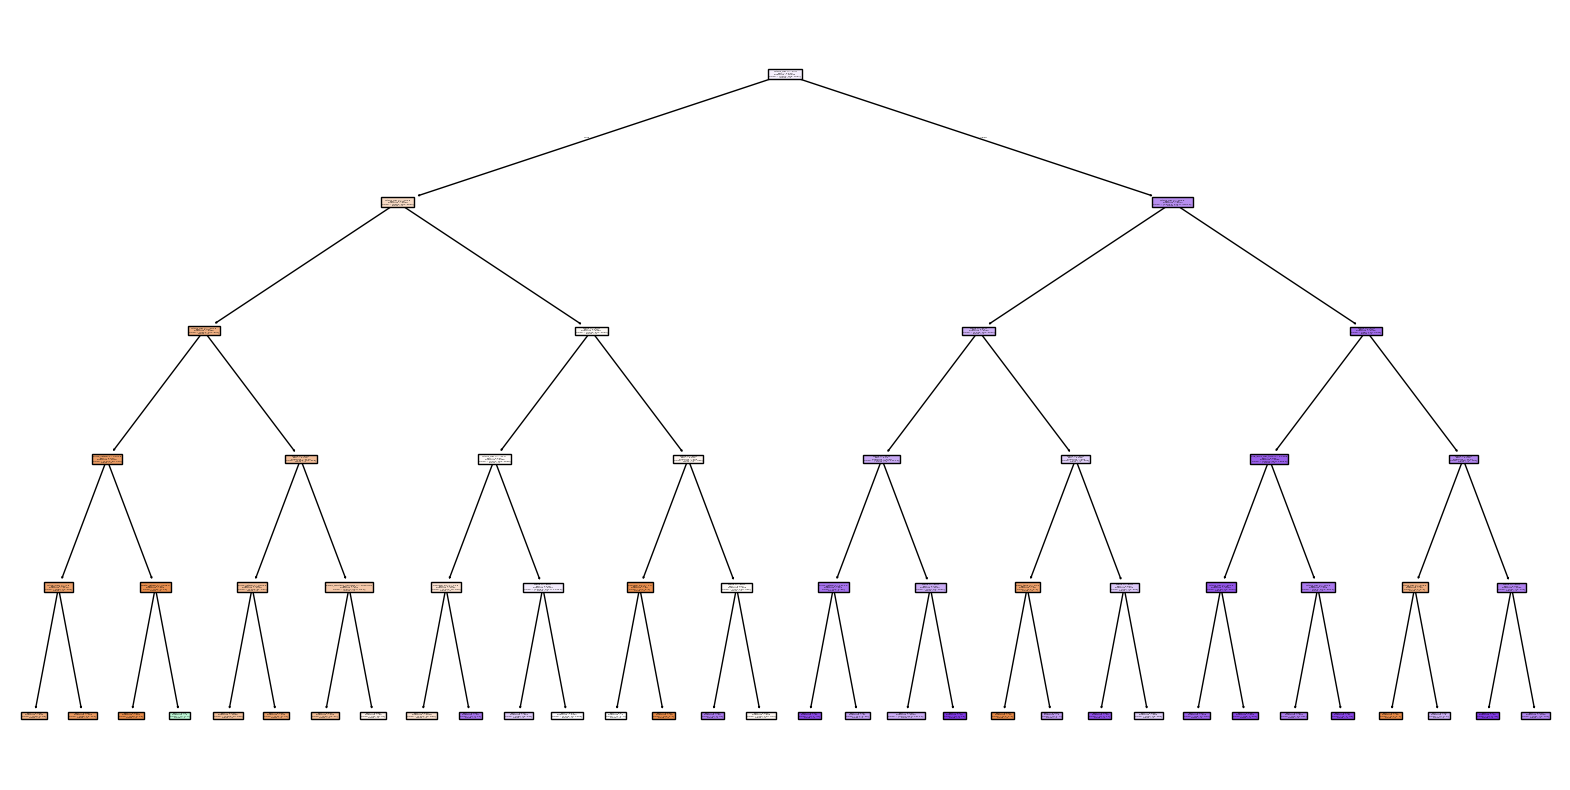

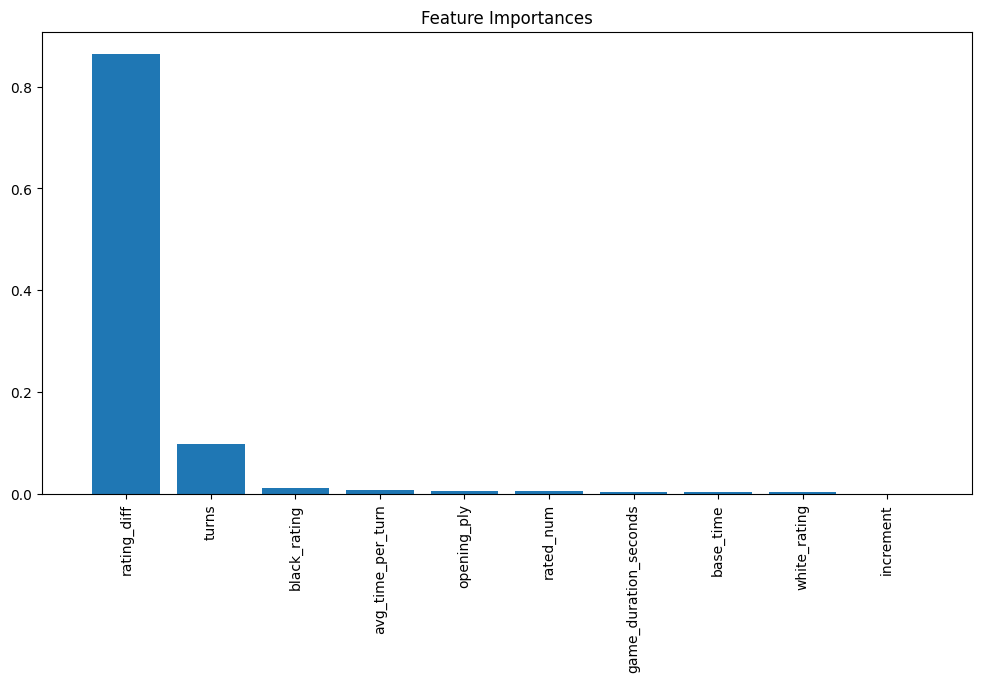

In [ ]:
#lets see why and how the model is making its predictions
#lets visualize the decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=['0', '1', '2'], filled=True)
plt.show()

#lets see the feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()
#as you can see, the most important feature is the elo difference, which makes a lot of sense. Smarter models might see paterns in the data that we can't see, but this is a good start.




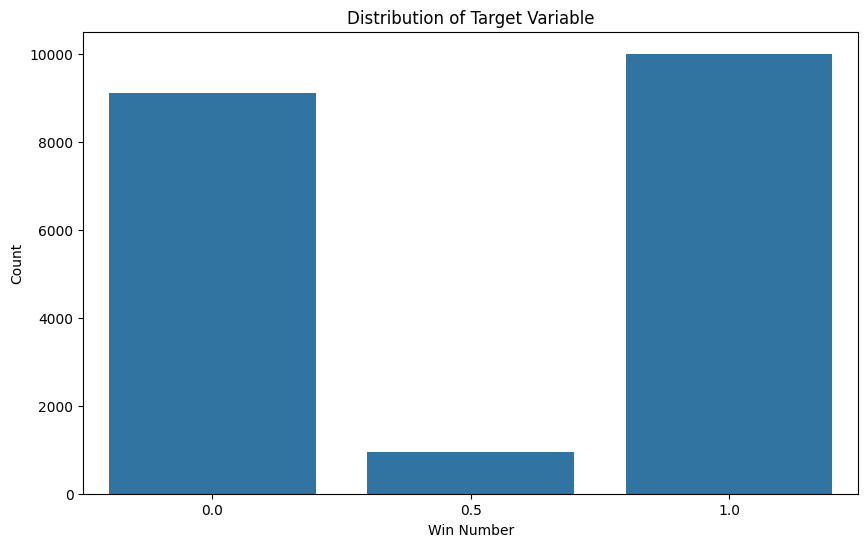

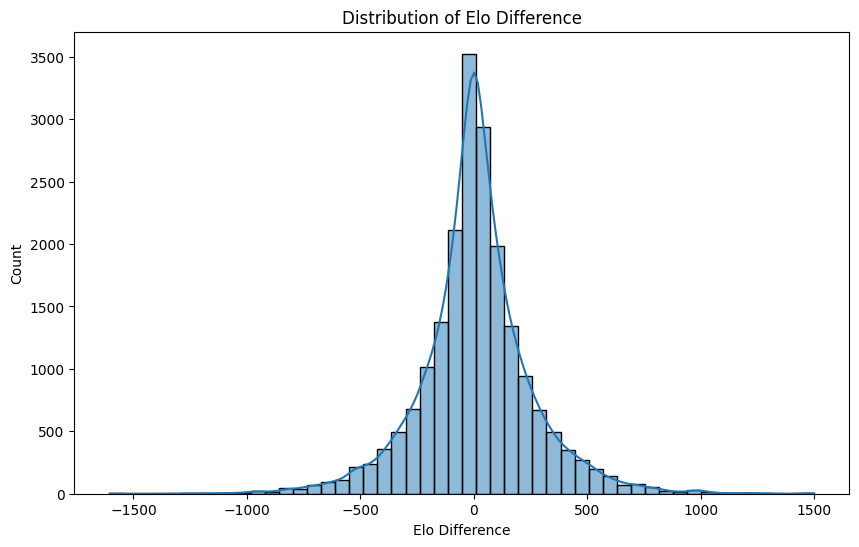

In [ ]:
#lets plot some more things from the model for fun:
#lets plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='win_num', data=procd)
plt.title('Distribution of Target Variable')
plt.xlabel('Win Number')
plt.ylabel('Count')
plt.show()
#logical that it has an edge on win.
#lets plot the distribution of the elo difference
plt.figure(figsize=(10, 6))
sns.histplot(procd['rating_diff'], bins=50, kde=True)
plt.title('Distribution of Elo Difference')
plt.xlabel('Elo Difference')
plt.ylabel('Count')
plt.show()
#looks pretty normally distrubuted! we can explore in data_analysis some more.

